# Predicting Volatility

**Project Goal**: 

In [44]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 1. Prepare Data

#### Import

Connect to a database:

In [45]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


Read Ambuja Data From Database

In [46]:
df_ambuja = repo.read_table(table_name="AMBUJACEM.BSE", limit=2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2024-06-05,576.75,601.75,550.35,599.05,493444.0
2024-06-04,670.60,670.60,518.00,557.40,1110009.0
2024-06-03,665.05,676.65,653.20,670.60,558604.0
2024-05-31,628.95,639.40,623.45,634.30,84665.0
2024-05-30,625.05,631.15,617.00,618.70,115283.0


#### Wrangle_data function

In [47]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations + 1)


    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)
    


    # Create "return" column
    df["return"] = df["close"].pct_change()*100
   


    # Return returns
    return df["return"].dropna()

Assertions to check the validity of the function:

In [48]:
y_ambuja = wrangle_data(ticker="AMBUJACEM.BSE", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_ambuja, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_ambuja) == 2500

# Is `y_ambuja` name "return"?
assert y_ambuja.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_ambuja.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_ambuja.index == y_ambuja.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_ambuja.isnull().sum() == 0

y_ambuja.head()

date
2014-04-04   -0.781059
2014-04-07    2.706027
2014-04-09    0.646707
2014-04-10    1.166111
2014-04-11    1.787815
Name: return, dtype: float64

#### Read Suzlon Data From Database

In [49]:
y_suzlon = wrangle_data(ticker= "SUZLON.BSE", n_observations=2500)

print("y_suzlon type:", type(y_suzlon))
print("y_suzlon shape:", y_suzlon.shape)
y_suzlon.head()

y_suzlon type: <class 'pandas.core.series.Series'>
y_suzlon shape: (2500,)


date
2014-04-11   -0.469169
2014-04-15   -7.138047
2014-04-16   -4.931109
2014-04-17    1.906941
2014-04-21    6.736527
Name: return, dtype: float64

### 2. Explore

The volatility time series plot:

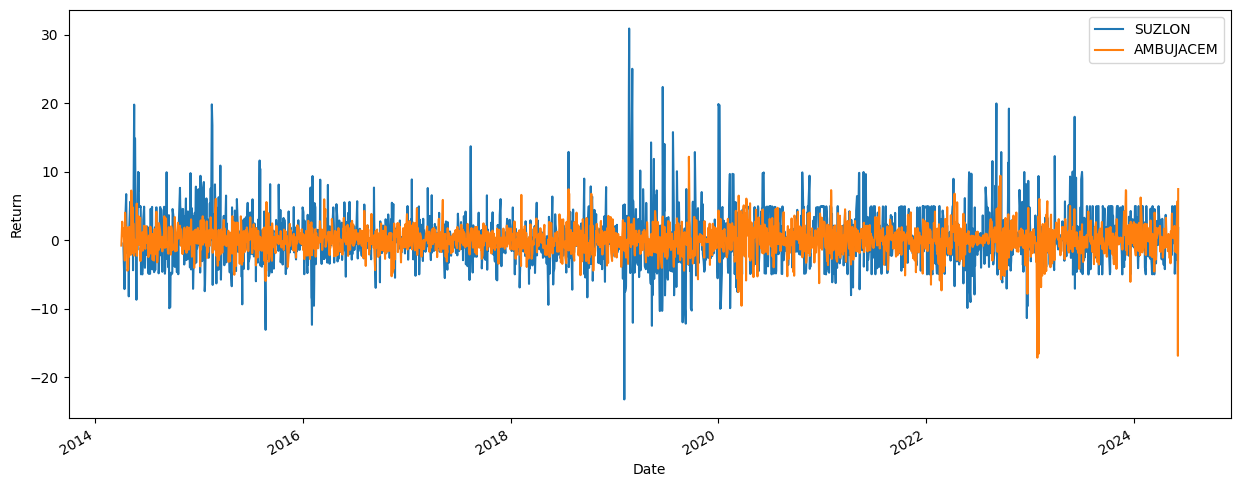

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_suzlon.plot(ax=ax, label="SUZLON")
y_ambuja.plot(ax=ax, label="AMBUJACEM")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

#### Conditional vs Unconditional Volatility

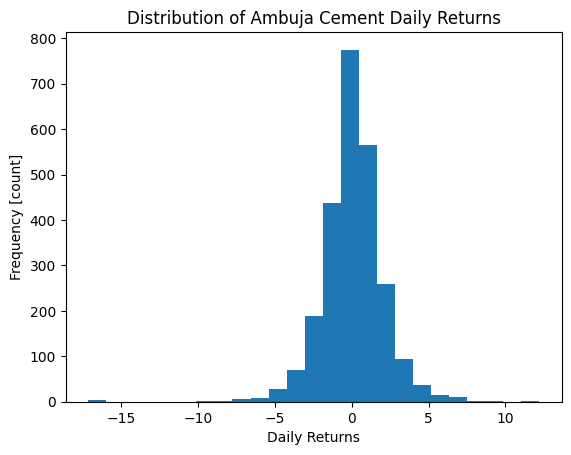

In [51]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(y_ambuja, bins=25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of Ambuja Cement Daily Returns")

plt.show();

- It turns out that returns follow an almost normal distribution, centered on 0. Volatility is the measure of the spread of these returns around the mean. 

- Volatility in finance is the same thing at standard deviation in statistics.

#### Calculating Daily Volatilty

In [52]:
suzlon_daily_volatility = y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.883260637655722
Ambuja Daily Volatility: 1.9923977393446801


#### Annual Volatility

In [53]:
suzlon_annual_volatility =suzlon_daily_volatility * np.sqrt(252)
ambuja_annual_volatility = ambuja_daily_volatility * np.sqrt(252)

print("Suzlon Annual Volatility:", suzlon_annual_volatility)
print("Ambuja Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 61.64485153969887
Ambuja Annual Volatility: 31.628333586199883


#### Rolling Volatility

In [54]:
ambuja_rolling_50d_volatility = y_ambuja.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(ambuja_rolling_50d_volatility))
print("rolling_50d_volatility shape:", ambuja_rolling_50d_volatility.shape)
ambuja_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2014-06-19    2.418507
2014-06-20    2.417004
2014-06-23    2.405667
2014-06-24    2.404823
2014-06-25    2.403236
Name: return, dtype: float64

#### Plot of Rolling Volatility

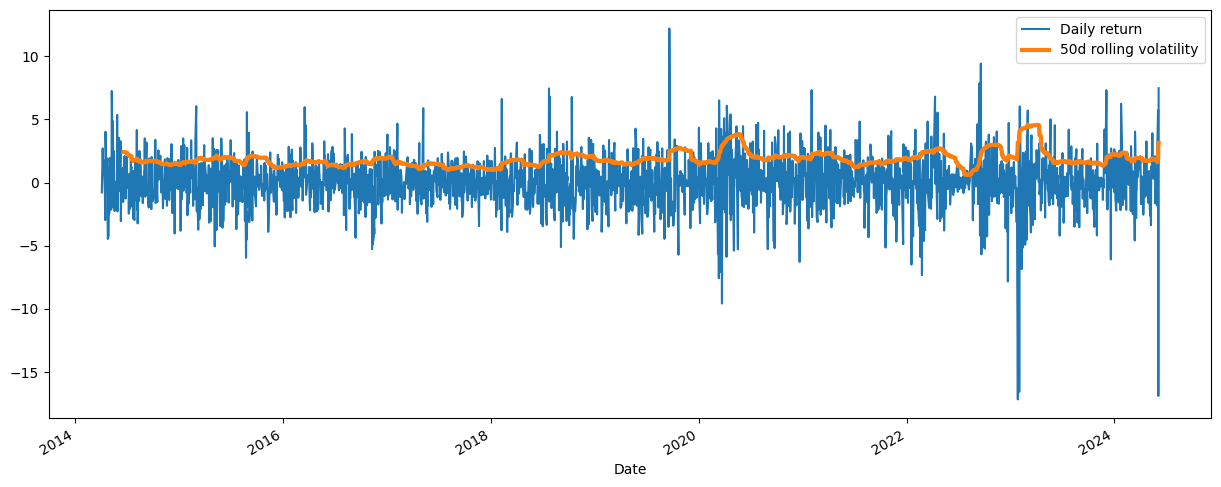

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_ambuja.plot(ax=ax, label="Daily return")


# Plot `ambuja_rolling_50d_volatility`
ambuja_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

- We can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. 

- We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

- This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day.

- But high volatility is caused by large changes in returns, which can be either positive or negative. 

- How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. 

- The other solution, which is more common in this context, is to square all the values.

#### Plot of Squared Returns

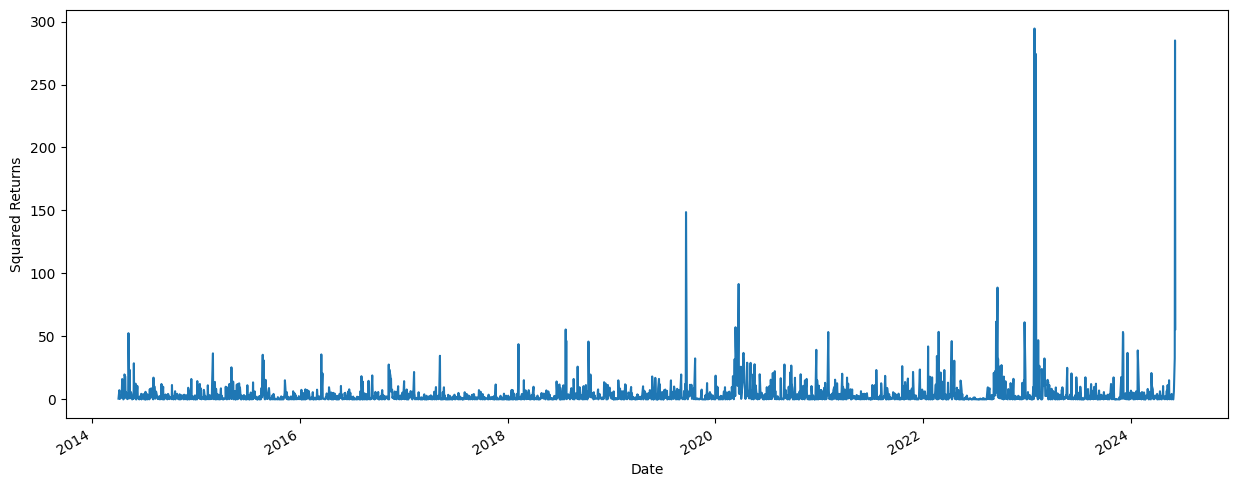

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_ambuja ** 2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

- Now, we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

#### ACF of Squared Returns

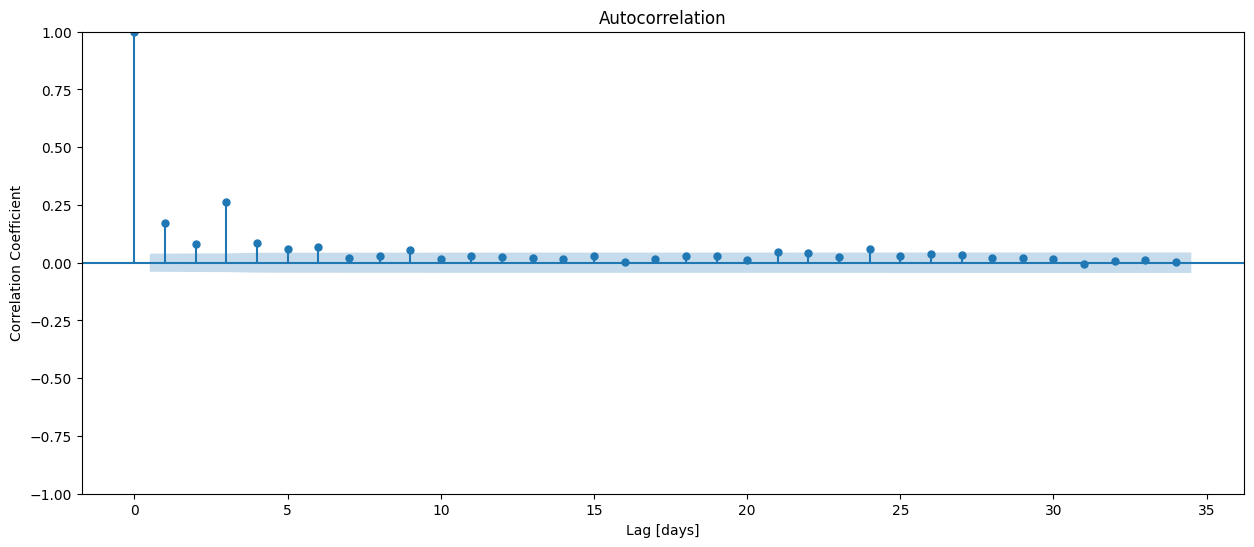

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_acf((y_ambuja ** 2), ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

#### PACF Plot of Squared Returns

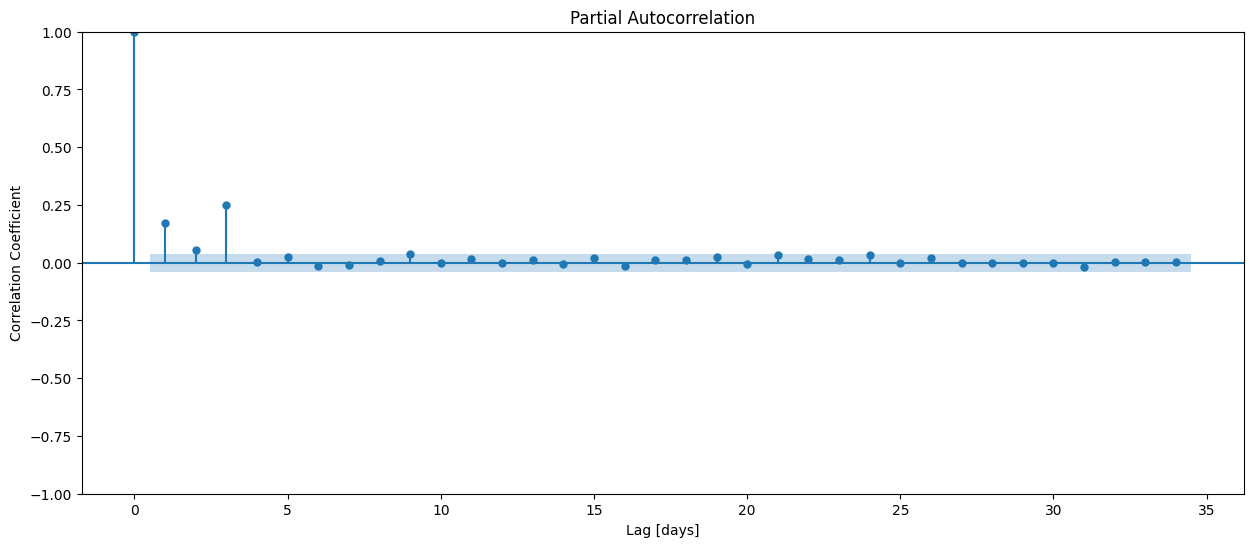

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf((y_ambuja ** 2), ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

- From the PACF plot, it looks like a lag of 3 would be a good starting point.

#### Split

#### Split Ambuja Data

In [59]:
cutoff_test = int(len(y_ambuja) * .8)
y_ambuja_train = y_ambuja.iloc[:cutoff_test]

print("y_ambuja_train type:", type(y_ambuja_train))
print("y_ambuja_train shape:", y_ambuja_train.shape)
y_ambuja_train.tail()

y_ambuja_train type: <class 'pandas.core.series.Series'>
y_ambuja_train shape: (2000,)


date
2022-05-20   -0.370675
2022-05-23    0.110238
2022-05-24   -0.523056
2022-05-25    0.041511
2022-05-26    1.009682
Name: return, dtype: float64

### 3. Build Model

#### Iterate

In [60]:
# Build and train model
model = arch_model(
    y_ambuja_train,
    p=1,
    q=1,
    rescale=False).fit(0)
print("model type:", type(model))

# Show model summary
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4013.0705009616295
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11
model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4013.07
Distribution:                  Normal   AIC:                           8034.14
Method:            Maximum Likelihood   BIC:                           8056.54
                                        No. Observations:                 2000
Date:                Thu, Jun 06 2024   Df Residuals:                     1999
Time:                        13:24:43   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0655  3.927e-02      1.668  9.530e-02 [-1.146e-02,  0.142]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1443  6.362e-02      2.268  2.331e-02   [1.962e-02,  0.269]
alpha[1]       0.0591  1.625e-02      3.638  2.750e-04 [2.726e-02,9.095e-02]
beta[1]        0.8986  3.074e-02     29.230 8.108e-188     [  0.838,  0.959]
============================================================================

Covariance estimator: robust
"""

#### A plot of Returns vs Predictions

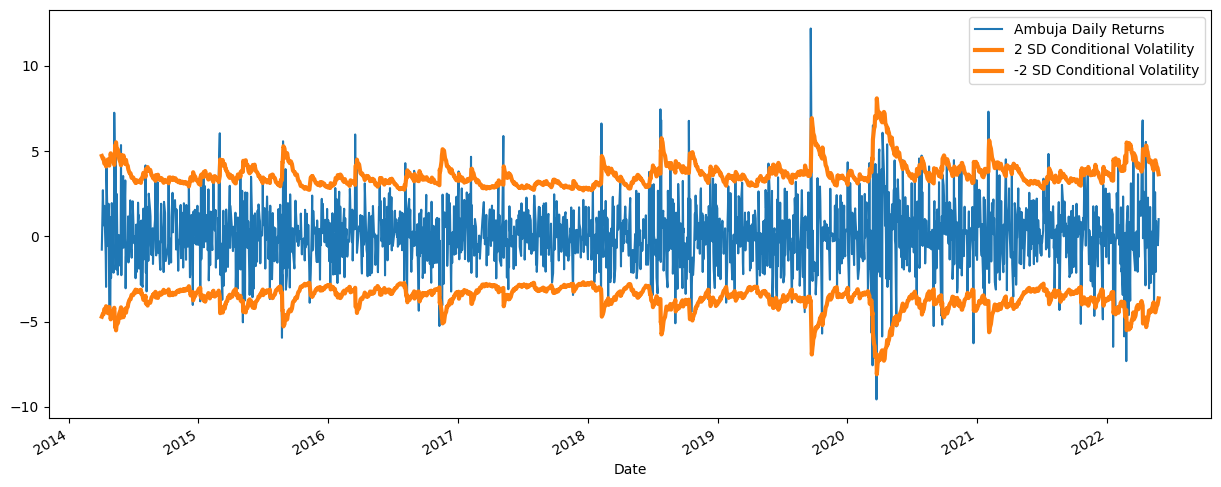

In [61]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_ambuja_train.plot(ax=ax, label="Ambuja Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax,
    color="C1",
    label="2 SD Conditional Volatility",
    linewidth=3 
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename()).plot(
    ax=ax,
    color="C1",
    label="-2 SD Conditional Volatility",
    linewidth=3 
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

#### A Plot of Standardized Residuals

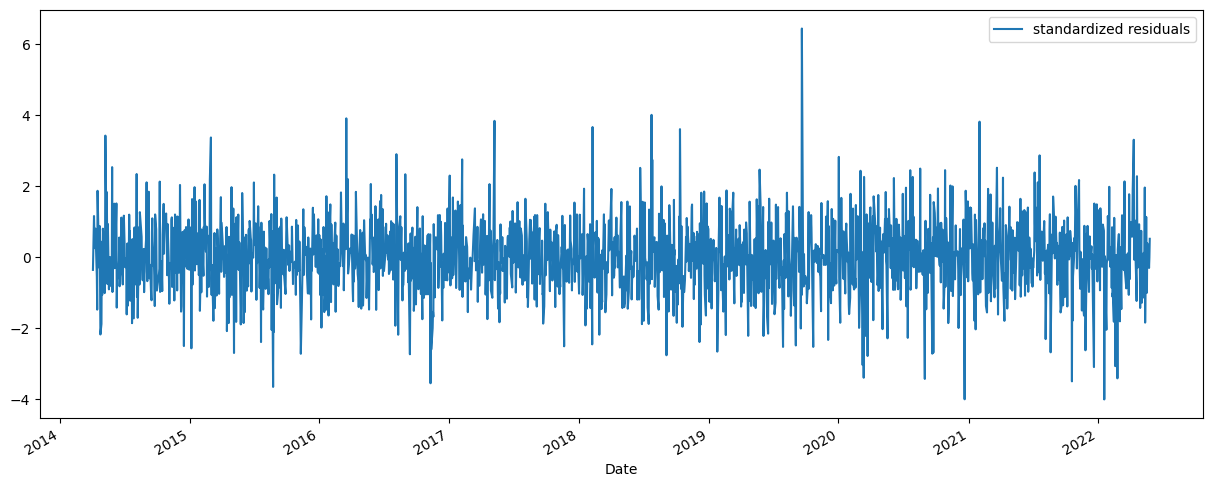

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="standardized residuals")

# Add axis labels
plt.xlabel("Date")

# Add legend
plt.legend();

#### Histogram of Standardized Residuals

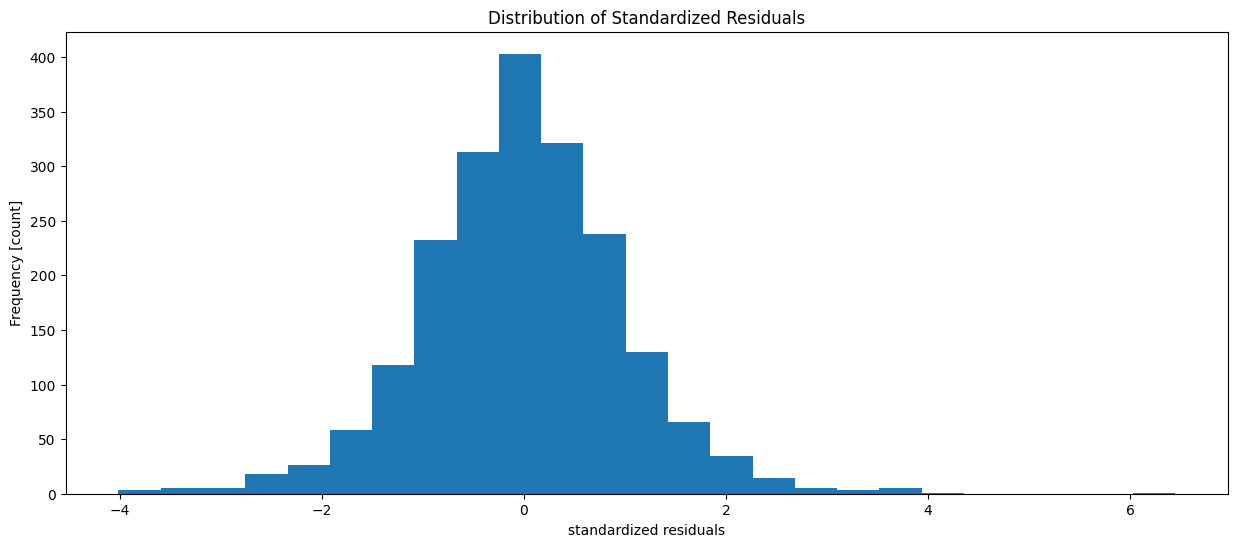

In [63]:
# Create histogram of standardized residuals, 25 bins
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("standardized residuals")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals");

#### ACF of Standardized Residuals

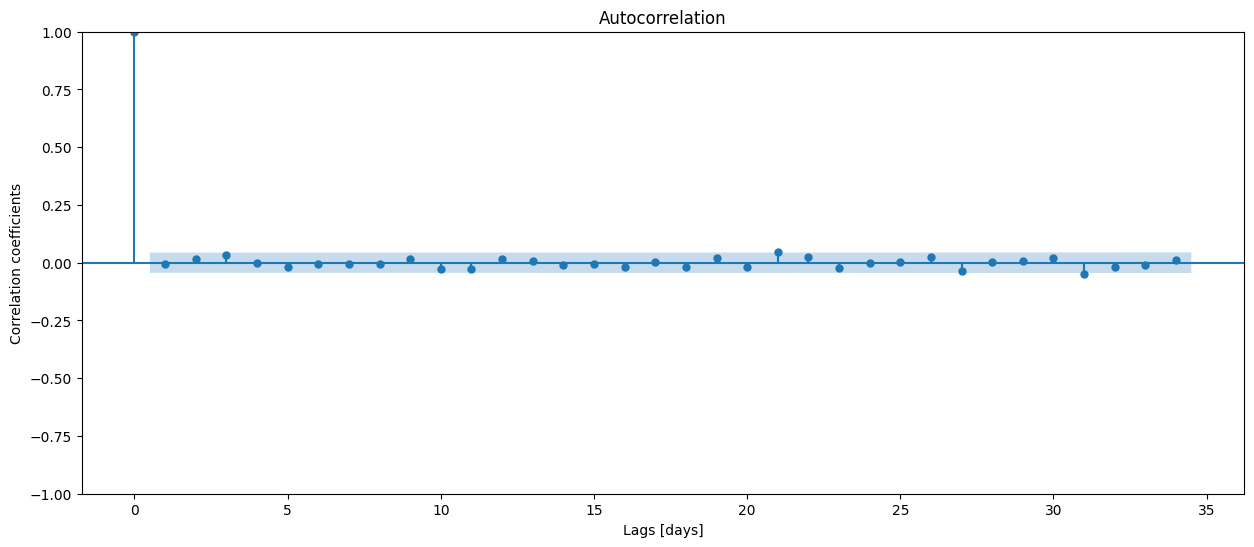

In [64]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid ** 2, ax=ax);

# Add axis labels
plt.xlabel("Lags [days]")
plt.ylabel("Correlation coefficients");


#### Evaluate

- One-day forecast using the walk-foreward validation:

In [65]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2022-05-26,3.180188


#### Walk-Forward Validation

In [66]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_ambuja) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_ambuja.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(
        y_train,
        p=1,
        q=1,
        rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2022-05-27    1.783308
2022-05-30    1.731377
2022-05-31    1.710639
2022-06-01    1.668324
2022-06-02    1.628457
dtype: float64

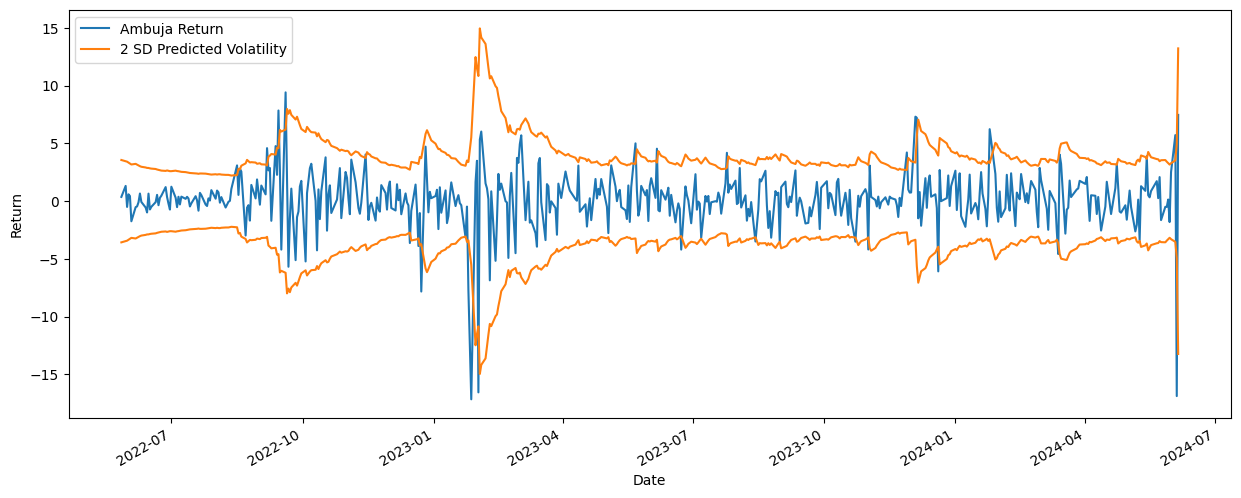

In [67]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_ambuja.tail(test_size).plot(ax=ax, label="Ambuja Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

#### 4. Communicate Results

Format Timestamp:

In [68]:
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
start=prediction.index[0] + pd.DateOffset(days=1) 
prediction_dates=pd.bdate_range(start=start, periods=prediction.shape[1])
prediction_dates[0].isoformat()
[d.isoformat() for d in prediction_dates]

['2024-06-05T00:00:00',
 '2024-06-06T00:00:00',
 '2024-06-07T00:00:00',
 '2024-06-10T00:00:00',
 '2024-06-11T00:00:00']

#### Generate 5-day volatility forecast

In [69]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1) 

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-06-04  6.616192  6.356403  6.108988  5.873443  5.649289
prediction_index type: <class 'list'>
prediction_index len: 5


['2024-06-05T00:00:00', '2024-06-06T00:00:00', '2024-06-07T00:00:00']

#### Clean_prediction Function

In [70]:
prediction = model.forecast(horizon=10, reindex=False).variance

In [71]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)


    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])
    

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]


    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** .5


    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index).to_dict()


    # Return Series as dictionary
    return prediction_formatted

In [72]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2024-06-05T00:00:00': 6.616192286535022,
 '2024-06-06T00:00:00': 6.356403079053569,
 '2024-06-07T00:00:00': 6.108987565037234,
 '2024-06-10T00:00:00': 5.873443189830083,
 '2024-06-11T00:00:00': 5.6492889048143455,
 '2024-06-12T00:00:00': 5.436064049276483,
 '2024-06-13T00:00:00': 5.233327264407509,
 '2024-06-14T00:00:00': 5.040655438680093,
 '2024-06-17T00:00:00': 4.857642684329347,
 '2024-06-18T00:00:00': 4.68389934518369}